#### Business Analytics FHDW 2025
# k-Nächste Nachbarn (k-NN)
## am Beispiel von Sitzrasenmähern

Im Beispielszenario möchte ein Hersteller von Sitzrasenmähern die Haushalte einer Stadt in potentielle Käufer und Nichtkäufer einordnen. Eine Stichprobe liefert der Datensatz `RidingMowers`. Der ist für eine echte Verwertung zu klein, erfüllt aber hier seinen Zweck.

Wir ergänzen die Datenpunkte um Nummern, um sie über den internen Index hinaus identifizieren zu können. 

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pyplot as plt

# Funktion für die Darstellung des Datensatzes als Scatter Plot
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o',
               label='Eigentümer' if showLabel else None, color='C1', **kwargs)
    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D',
               label='Nichteigentümer' if showLabel else None, color='C0', **kwargs)
    plt.xlabel('Einkommen')
    plt.ylabel('Grundstücksgröße')
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income+2, row.Lot_Size))

mower_df = pd.read_csv('./Daten/RidingMowers.csv')
mower_df['Number'] = mower_df.index+1

mower_df

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5
5,110.1,19.2,Owner,6
6,108.0,17.6,Owner,7
7,82.8,22.4,Owner,8
8,69.0,20.0,Owner,9
9,93.0,20.8,Owner,10


Auch, wenn wir in diesem Beispiel aus Gründen der Anschaulichkeit nur wenige Daten haben, teilen wir Trainings- und Validierungsdaten ab.

Dann erzeugen wir einen neuen Haushalt `new_household` mit einem Einkommen von 60.000 und einem Grundstück von 2.000.

Alle Daten - mit dem neuen Haushalt - stellen wir graphisch dar.

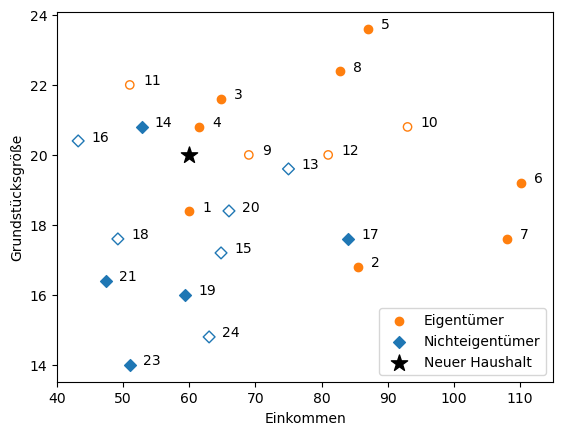

In [2]:
train_data, valid_data = train_test_split(mower_df, test_size=0.4, random_state=26)

new_household = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])

fig, ax = plt.subplots()
plotDataset(ax, train_data)
# Validierungsdatenpunkte sind farblich nicht ausgefüllt:
plotDataset(ax, valid_data, showLabel=False, facecolors='none')
ax.scatter(new_household.Income, new_household.Lot_Size, marker='*',
           label='Neuer Haushalt', color='black', s=150)

plt.xlabel('Einkommen')
plt.ylabel('Grundstücksgröße')
ax.set_xlim(40, 115)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)
plt.show()

Dem neuen Haushalt euklidisch am nächsten ist der Trainings-Datensatz 4 mit einem Einkommen von 61.500 und einem Grundstück von 2.080. Nutzen wir hier 1-NN, würden wir den neuen Haushalt wie 4 als Eigentümer klassifizieren. Nutzen wir $k=3$, sind die nächsten Nachbarn 4, 14 und 1. Zwei davon sind Eigentümer; diese Mehrheit würde wieder zur dieser Klassifizierung führen.

Das können wir rechnerisch bestätigen. Da wir Einkommen und Grundstücksgröße als Prädiktoren nutzen wollen - Geld und Fläche - müssen wir diese Daten zunächst normieren. Danach liefert uns ein `NearestNeighbors`-Objekt aus *scikit-learn* mit `fit` die Anpassung unserer Trainingsdaten, so dass wir mit `kneighbors` die drei Nachbarn unseres neuen Haushalts bekommen.

In [3]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_data[['Income', 'Lot_Size']])

mower_norm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]),
                                     columns=['zIncome', 'zLot_Size']),
                        mower_df[['Ownership', 'Number']]], axis=1)
train_norm = mower_norm.iloc[train_data.index]
valid_norm = mower_norm.iloc[valid_data.index]
new_household_norm = pd.DataFrame(scaler.transform(new_household),
                                  columns=['zIncome', 'zLot_Size'])

knn = NearestNeighbors(n_neighbors=3)
knn.fit(train_norm.iloc[:, 0:2])
distances, indices = knn.kneighbors(new_household_norm)

train_norm.iloc[indices[0], :]

,zIncome,zLot_Size,Ownership,Number
3,-0.409776,0.743358,Owner,4
13,-0.804953,0.743358,Nonowner,14
0,-0.477910,-0.174908,Owner,1


## Was für ein $k$ sollten wir wählen?

Ist $k$ zu niedrig, besteht die Gefahr, dass diese (Über-)Anpassung sich auf das Rauschen in den Daten bezieht. Höhere Werte glätten das weg, zu hohe $k$ ignorieren aber die lokalen Strukturen, die gerade diese Methode gut nutzen kann. Im Extremfall $k=n$ landen wir bei einem naiven Ansatz einer Gesamtmehrheit. Wir müssen also ein Gleichgewicht finden zwischen Überanpassung an die Prädiktorinformationen und dem vollständigen Ignorieren dieser.

Praktischerweise nutzen wir Rechner und können daher schlicht ausprobieren (lassen), welches $k$ die beste Klassifikationsperformance bzw. den kleinsten Fehler liefert. Allgemein sollte das gewählte $k$ aber ungerade sein, damit es nicht zu "unentschieden" bei der Mehrheitssuche kommt.

Im Folgenden müssen wir beachten, dass hier der Trainingsprozess die Validierungsdaten nutzt, um das beste $k$ zu ermitteln. Eigentlich bräuchten wir also einen dritten Test, um die Qualität der Prädiktion bei Datensätzen zu prüfen, die das Verfahren hier "noch nicht kennt".

In [4]:
train_X = train_norm[['zIncome', 'zLot_Size']]
train_y = train_norm['Ownership']
valid_X = valid_norm[['zIncome', 'zLot_Size']]
valid_y = valid_norm['Ownership']
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
    
results = pd.DataFrame(results)
results

,k,accuracy
0,1,0.6
1,2,0.7
2,3,0.8
3,4,0.9
4,5,0.7
5,6,0.9
6,7,0.9
7,8,0.9
8,9,0.9
9,10,0.8


Wählen wir mit diesen Informationen nun $k=4$, ergibt sich das hier endgültige Prädiktionsobjekt, mit dem wir den neuen Haushalt von oben klassifizieren und uns die zugehörigen Parameter ausgeben lassen.

In [5]:
mower_X = mower_norm[['zIncome', 'zLot_Size']]
mower_y = mower_norm['Ownership']
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)

distances, indices = knn.kneighbors(new_household_norm)
print(knn.predict(new_household_norm))
print('Distances', distances)
print(mower_norm.iloc[indices[0], :])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## Setzen einer Schwelle/Cutoff

Die Mehrheitsentscheidung bei k-NN kann praktisch auf einen Cutoff-Wert abgebildet werden. Zunächst können wir die Verhältnisse der nachbarlichen Klassenzugehörigkeiten als Wahrscheinlichkeiten interpretieren, mit denen unser zu klassifizierender Datensatz einer davon angehört. Z. B. ergaben sich für unseren neuen Haushalt bei $k=4$ drei Eigentümer, d. h. eine Wahrscheinlichkeit von 0.75 für Eigentümer, 0.25 für Nichteigentümer.

Die einfache Mehrheitsregel entspricht also einem Cutoff von 0.5. Bei Bedarf können wir auf Basis der Wahrscheinlichkeiten eine andere Schwelle definieren, je nachdem, ob wir die Genauigkeit maximieren wollen, oder die Kosten für Fehlklassifikationen berücksichtigen müssen.

## Aufgabe

Wir betrachten den bekannten Datensatz *BostonHousing.csv* über Stadtgebiete (*tracts*) im Rahmen einer Volkszählung. Die Daten weisen ein ethisches Problem auf (Kategorie *b*, "the proportion of blacks by town", im Jahre 1978 offenbar ein akzeptiertes Kriterium, heute in der Literatur oft einfach ausgelassen), das wir an dieser Stelle nur technisch lösen können.

Ermitteln Sie ein geeignetes k-NN-Vorhersagemodell für die Zielvariable *medv* (Medianwert von eigentümerbewohnten Häusern in $ 1.000):
* Berücksichtigen Sie alle 12 Prädiktoren.
* Prüfen Sie *k* von 1 bis 5. Was ist das beste *k*, was bedeutet der Wert?
* Wir haben es nun mit einer numerischen Zielvariable zu tun, Sie benötigen also den `KNeighborsRegressor` und auch einen geeigneten Wert (statt `accuracy_score`) zur Beurteilung der *k*s.
* Denken Sie an die Normierung der Daten.

Sagen Sie mit dem besten *k* den Zielwert für den neuen Datenpunkt `{'crim': 0.2, 'zn': 0, 'indus':7, 'chas':0, 'nox':0.538, 'rm': 6, 'age':62, 'dis':4.7, 'rad':4, 'tax':307, 'ptratio':21, 'lstat':10}` voraus.